In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as scpy
from scipy import stats
from scipy import ndimage
from skimage.transform import resize
import seaborn as sns
from statannot import add_stat_annotation
import dionysus as d

import csv
import pandas as pd
import pickle

from sklearn.cluster import KMeans

from mpl_toolkits.mplot3d import Axes3D
from skimage import io

import importlib
import helper_functions
importlib.reload(helper_functions)
from helper_functions import *

%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'arial'
rcParams.update({'font.size': 12})

#### Plot data from quantifying TIRF-SIM data (from running podosome_analysis_other_species.py)

In [3]:
at_dict = pickle.load(open('AT_Analyzed/ATIndividualQuant.pickle','rb'))
ap_dict = pickle.load(open('AP_Analyzed/APIndividualQuant.pickle','rb'))
aa_dict = pickle.load(open('AA_Analyzed/AAIndividualQuant.pickle','rb'))

In [4]:
paxillin_d = ap_dict['all_diameter']
talin_d = at_dict['all_diameter']
actinin_d = aa_dict['all_diameter']

dia = np.hstack([paxillin_d, talin_d, actinin_d])
spec = np.hstack([['Paxillin']*len(paxillin_d),['Talin']*len(talin_d),['Actinin']*len(actinin_d)])

dia_df = pd.DataFrame(list(zip(dia,spec)),columns = ['Diameter','Species'])

In [7]:
t_tp, p_pt = scpy.stats.ttest_ind(paxillin_d,talin_d)
t_ta, p_ta = scpy.stats.ttest_ind(talin_d,actinin_d)
t_pa, p_pa = scpy.stats.ttest_ind(paxillin_d,actinin_d)
print(p_pt,p_ta,p_pa)

0.00022218562932347085 0.010353862984961703 5.66706388380935e-06


<IPython.core.display.Javascript object>


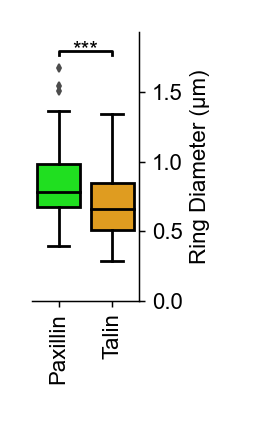

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Paxillin v.s. Talin: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.076e-04 U_stat=5.260e+03


In [5]:
plt.figure(figsize=(1.5,2.5))
# plt.boxplot([paxillin_d,talin_d,actinin_d], labels=['paxillin','talin','actinin'])

# sns.boxplot(x='Species', y='Diameter', data=dia_df,showfliers=False,palette="Set2")
# sns.swarmplot(x='Species', y='Diameter',  data=dia_df,color=".2")

df = dia_df[dia_df['Species'] != 'Actinin']
x = 'Species'
y = 'Diameter'
box_pairs=[
    ("Paxillin", "Talin"),
#     ("Paxillin", "Actinin"),
#     ("Talin", "Actinin")
    ]


flierprops = dict(marker='d', markersize=3)

palette = ['lime','orange'] #,'orange']
ax = sns.boxplot(x=x, y=y,data=df,showfliers=True,flierprops=flierprops,palette=palette)
# sns.stripplot(x=x, y=y,  data=df,color=".2",alpha=0.5)
add_stat_annotation(ax, data=df, x=x, y=y, box_pairs=box_pairs,
                    test='Mann-Whitney', loc='inside', verbose=2,text_offset=-5)

for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')

    # iterate over whiskers and median lines
    for j in range(6*2+1):
         ax.lines[j].set_color('black')

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 1))

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.yticks([0,0.5,1,1.5])

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
            
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Ring Diameter (\u03BCm)')
plt.tight_layout()
# 
# plt.savefig('../../../SH-CH/WorkingFiguresCurrent/Figure7_AdhesionAndCap/IndividualPlots/RingDiameter_PaxTalin.pdf',transparent=True,dpi=300,bbox_inches='tight')


In [13]:
for spec in np.unique(dia_df['Species']):
    spec_df = dia_df[dia_df['Species']==spec]
    print('Species: %s mean: %.2f std: %.2f'%(spec,spec_df['Diameter'].mean(), spec_df['Diameter'].std()))

Species: Actinin mean: 0.58 std: 0.21
Species: Paxillin mean: 0.83 std: 0.28
Species: Talin mean: 0.69 std: 0.23


In [9]:
out_in_paxillin = out_in_stack(ap_dict['in_other'],ap_dict['out_other'])
out_in_talin = out_in_stack(at_dict['in_other'],at_dict['out_other'])

out_in_actin = []
for a_dict in [ap_dict, at_dict, aa_dict]:
    out_in_actin.append(out_in_stack(a_dict['in_act'],a_dict['out_act']))
    
out_in_actin = np.vstack(out_in_actin)

<IPython.core.display.Javascript object>


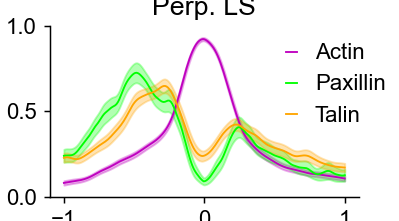

In [10]:
xs = np.linspace(-1,1,len(out_in_actin[0]))
colors = sns.color_palette("bright")

plt.figure(figsize=(2.25,1.25))
actin_mean = np.mean([max_min_scaled(o) for o in out_in_actin],axis=0)
actin_ci = 1.96*stats.sem([max_min_scaled(o) for o in out_in_actin],axis=0)
plt.plot(xs, actin_mean,c='m',lw=1)
plot_fill_between(plt,xs, actin_mean, actin_ci, alpha=0.3, color='m')

paxillin_mean = np.mean([max_min_scaled(o) for o in out_in_paxillin],axis=0)
paxillin_ci = 1.96*stats.sem([max_min_scaled(o) for o in out_in_paxillin],axis=0)
plt.plot(xs, paxillin_mean,c='lime',lw=1)
plot_fill_between(plt,xs, paxillin_mean, paxillin_ci, alpha=0.3, color='lime')

talin_mean = np.mean([max_min_scaled(o) for o in out_in_talin],axis=0)
talin_ci = 1.96*stats.sem([max_min_scaled(o) for o in out_in_talin],axis=0)
plt.plot(xs, talin_mean,c='orange',lw=1)
plot_fill_between(plt,xs, talin_mean, talin_ci, alpha=0.3, color='orange')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(['Actin','Paxillin','Talin'],handlelength=0.5,bbox_to_anchor = [0.7, 0.3],frameon=False) #,'Actinin'
plt.title('Perp. LS')
plt.ylabel('Norm. Intensity (a.u.)')
plt.xlabel('Distance From Podosome (\u03BCm)')
plt.yticks(ticks=[0,0.5,1.])
# plt.tight_layout()

# plt.savefig('../../../SH-CH/WorkingFiguresCurrent/Figure7_AdhesionAndCap/IndividualPlots/PerpLS_PaxTalin.pdf',transparent=True,dpi=300,bbox_inches='tight')
plt.show()

In [12]:
actinin_dist_in = aa_dict['all_dist2peak_in']
actinin_dist_out = aa_dict['all_dist2peak_out']
actinin_FWHM_in = aa_dict['all_FWHM_in']
actinin_FWHM_out = aa_dict['all_FWHM_out']
actinin_meas = np.hstack([actinin_dist_in,actinin_dist_out,actinin_FWHM_in,actinin_FWHM_out])
actinin_type = np.hstack([['Distance']*(len(actinin_dist_in) + len(actinin_dist_out)), ['FWHM']*(len(actinin_FWHM_in) + len(actinin_dist_out))])
actinin_dir = np.hstack([['In']*len(actinin_dist_in), ['Out']*len(actinin_dist_out), ['In']*len(actinin_FWHM_in), ['Out']*len(actinin_FWHM_out)])
actinin_spec = ['Actinin']*len(actinin_meas)

paxillin_dist_in = ap_dict['all_dist2peak_in']
paxillin_dist_out = ap_dict['all_dist2peak_out']
paxillin_FWHM_in = ap_dict['all_FWHM_in']
paxillin_FWHM_out = ap_dict['all_FWHM_out']
paxillin_meas = np.hstack([paxillin_dist_in,paxillin_dist_out,paxillin_FWHM_in,paxillin_FWHM_out])
paxillin_type = np.hstack([['Distance']*(len(paxillin_dist_in) + len(paxillin_dist_out)), ['FWHM']*(len(paxillin_FWHM_in) + len(paxillin_dist_out))])
paxillin_dir = np.hstack([['In']*len(paxillin_dist_in), ['Out']*len(paxillin_dist_out), ['In']*len(paxillin_FWHM_in), ['Out']*len(paxillin_FWHM_out)])
paxillin_spec = ['Paxillin']*len(paxillin_meas)

talin_dist_in = at_dict['all_dist2peak_in']
talin_dist_out = at_dict['all_dist2peak_out']
talin_FWHM_in = at_dict['all_FWHM_in']
talin_FWHM_out = at_dict['all_FWHM_out']
talin_meas = np.hstack([talin_dist_in,talin_dist_out,talin_FWHM_in,talin_FWHM_out])
talin_type = np.hstack([['Distance']*(len(talin_dist_in) + len(talin_dist_out)), ['FWHM']*(len(talin_FWHM_in) + len(talin_dist_out))])
talin_dir = np.hstack([['In']*len(talin_dist_in), ['Out']*len(talin_dist_out), ['In']*len(talin_FWHM_in), ['Out']*len(talin_FWHM_out)])
talin_spec = ['Talin']*len(talin_meas)

all_meas = np.hstack([paxillin_meas,talin_meas,actinin_meas])
all_type = np.hstack([paxillin_type,talin_type,actinin_type])
all_dir = np.hstack([paxillin_dir,talin_dir,actinin_dir])
all_spec = np.hstack([paxillin_spec,talin_spec,actinin_spec])



peak_df = pd.DataFrame(np.array([all_meas,all_type,all_dir,all_spec]).T, 
                       columns = ['Measurement','Type','Direction','Species'])

peak_df['Measurement'] = pd.to_numeric(peak_df['Measurement'])

In [13]:
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

<IPython.core.display.Javascript object>


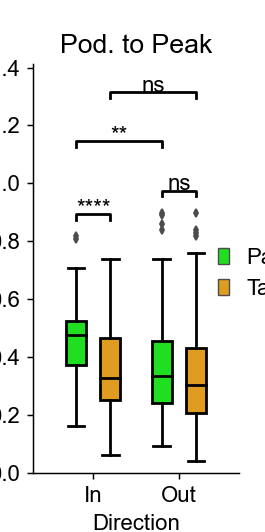

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Out_Paxillin v.s. Out_Talin: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.569e-01 U_stat=4.662e+03
In_Paxillin v.s. In_Talin: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.199e-05 U_stat=6.266e+03
In_Paxillin v.s. Out_Paxillin: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.704e-03 U_stat=2.508e+03
In_Talin v.s. Out_Talin: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.243e-01 U_stat=1.103e+04


In [14]:
from statannot import add_stat_annotation

fig, ax = plt.subplots(figsize=(1.5,3.))

df = peak_df[peak_df['Species'] != 'Actinin']
df = df[df['Type']=='Distance']
x = 'Direction'
y = 'Measurement'
hue = 'Species'
hue_order=['Paxillin','Talin']#,'Actinin']
box_pairs=[
    (("In", "Paxillin"), ("In", "Talin")),
#     (("In", "Paxillin"), ("In", "Actinin")),
#     (("In", "Talin"), ("In", "Actinin")),
    (("Out", "Paxillin"), ("Out", "Talin")),
#     (("Out", "Paxillin"), ("Out", "Actinin")),
#     (("Out", "Talin"), ("Out", "Actinin")),
    
    (("In", "Paxillin"), ("Out", "Paxillin")),
    (("In", "Talin"), ("Out", "Talin")),
#     (("In", "Actinin"), ("Out", "Actinin"))
    ]

palette = ['lime','orange']#,'orange']
ax = sns.boxplot(x=x, y=y, hue=hue,data=df,showfliers=True,
                 flierprops=flierprops,palette=palette)
add_stat_annotation(ax, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs,
                    test='Mann-Whitney', loc='inside', verbose=2,
                    line_offset = 0.1,text_offset=-2)


# sns.stripplot(x='Direction', y='Measurement', hue='Species', color='k',
#             data=peak_df[peak_df['Type']=='Distance'],split=True,alpha=0.5)

for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')

    # iterate over whiskers and median lines
    for j in range(6*4+4):
        ax.lines[j].set_color('black')
        
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 1))

adjust_box_widths(fig, 0.6)

h, l = ax.get_legend_handles_labels()
plt.legend(h[:3],l[:3],handlelength=0.5,bbox_to_anchor = [0.8, 0.6],frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylabel('Distance (\u03BCm)')
plt.title('Pod. to Peak')
plt.tight_layout()

# plt.savefig('../../../SH-CH/WorkingFiguresCurrent/Figure7_AdhesionAndCap/IndividualPlots/PeakDist_PaxTalin.pdf',transparent=True,dpi=300,bbox_inches='tight')


In [15]:
for spec in np.unique(dia_df['Species']):
    spec_df = df[df['Species']==spec]
    for d in ['In','Out']:
        spec_d_df = spec_df[spec_df['Direction']==d]
        print('Species: %s Direction %s mean: %.2f std: %.2f'%(spec,d,spec_d_df['Measurement'].mean(), spec_d_df['Measurement'].std()))
        

Species: Actinin Direction In mean: nan std: nan
Species: Actinin Direction Out mean: nan std: nan
Species: Paxillin Direction In mean: 0.46 std: 0.14
Species: Paxillin Direction Out mean: 0.38 std: 0.19
Species: Talin Direction In mean: 0.35 std: 0.15
Species: Talin Direction Out mean: 0.34 std: 0.19


<IPython.core.display.Javascript object>


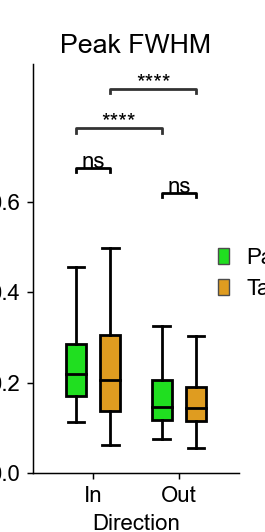

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Out_Paxillin v.s. Out_Talin: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.227e+03
In_Paxillin v.s. In_Talin: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.613e-01 U_stat=5.007e+03
In_Paxillin v.s. Out_Paxillin: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.169e-05 U_stat=2.693e+03
In_Talin v.s. Out_Talin: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.292e-06 U_stat=1.350e+04


In [16]:
from statannot import add_stat_annotation

fig, ax = plt.subplots(figsize=(1.5,3.))

df = peak_df[peak_df['Species'] != 'Actinin']
df = df[df['Type']=='FWHM']
x = 'Direction'
y = 'Measurement'
hue = 'Species'
hue_order=['Paxillin','Talin']#,'Actinin']
box_pairs=[
    (("In", "Paxillin"), ("In", "Talin")),
#     (("In", "Paxillin"), ("In", "Actinin")),
#     (("In", "Talin"), ("In", "Actinin")),
    (("Out", "Paxillin"), ("Out", "Talin")),
#     (("Out", "Paxillin"), ("Out", "Actinin")),
#     (("Out", "Talin"), ("Out", "Actinin")),
    
    (("In", "Paxillin"), ("Out", "Paxillin")),
    (("In", "Talin"), ("Out", "Talin")),
#     (("In", "Actinin"), ("Out", "Actinin"))
    ]

palette = ['lime','orange']#,'orange']
ax = sns.boxplot(x=x, y=y, hue=hue,data=df,showfliers=False,palette=palette)
add_stat_annotation(ax, data=df, x=x, y=y, hue=hue, box_pairs=box_pairs,
                    test='Mann-Whitney', loc='inside', verbose=2,
                    line_offset = 0.1,text_offset=-2)


# sns.stripplot(x=x,y=y, hue=hue,color='k',
#             data=df,split=True,alpha=0.5)

for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')

    # iterate over whiskers and median lines
    for j in range(6*3+4):
         ax.lines[j].set_color('black')
            
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 1))

adjust_box_widths(fig, 0.6)

h, l = ax.get_legend_handles_labels()
plt.legend(h[:3],l[:3],handlelength=0.5,bbox_to_anchor = [0.8, 0.6],frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.yticks([0,0.2,0.4,0.6])

plt.ylabel('FWHM (\u03BCm)')
plt.title('Peak FWHM')
plt.tight_layout()

# plt.savefig('../../../SH-CH/WorkingFiguresCurrent/Figure7_AdhesionAndCap/IndividualPlots/PeakFWHM_PaxTalin.pdf',transparent=True,dpi=300,bbox_inches='tight')


In [17]:
for spec in np.unique(dia_df['Species']):
    spec_df = df[df['Species']==spec]
    for d in ['In','Out']:
        spec_d_df = spec_df[spec_df['Direction']==d]
        print('Species: %s %s mean: %.2f std: %.2f'%(spec,d,spec_d_df['Measurement'].mean(), spec_d_df['Measurement'].std()))
        

Species: Actinin In mean: nan std: nan
Species: Actinin Out mean: nan std: nan
Species: Paxillin In mean: 0.25 std: 0.12
Species: Paxillin Out mean: 0.18 std: 0.10
Species: Talin In mean: 0.23 std: 0.10
Species: Talin Out mean: 0.17 std: 0.08
